Este colab fue desarrollado por Arnold Charry Armero.

# Minimización del Makespan con Restricciones

Quince trabajos, cada uno con su tiempo de procesamiento, deben programarse en tres máquinas. Si dos trabajos no pueden programarse en la misma máquina, se denominan trabajos conflictivos. La tabla 1 enumera los ID de los trabajos, los tiempos de procesamiento y los conjuntos de trabajos conflictivos. Por ejemplo, no podemos programar ningún par de trabajos de los trabajos 2, 5, 8 en la misma máquina. Tenga en cuenta que un trabajo puede no tener trabajos conflictivos.

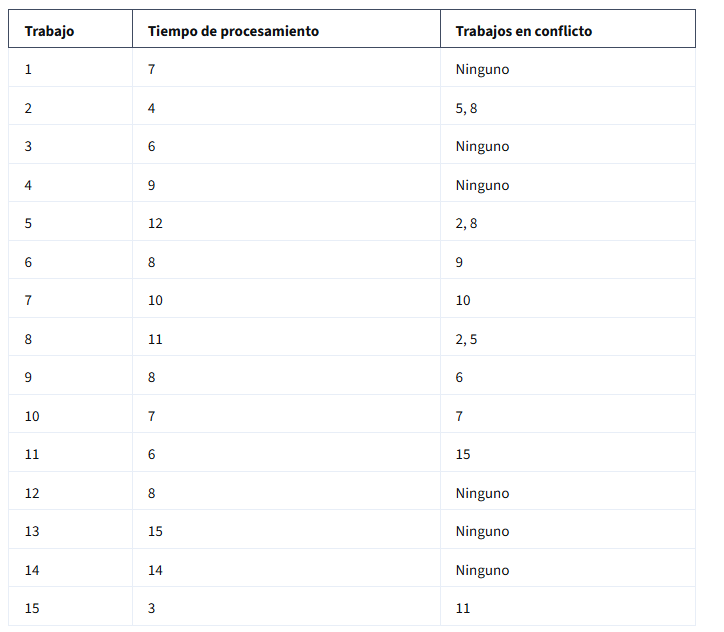

Queremos programar los trabajos para minimizar el makespan. Por ejemplo, podemos programar los trabajos 1, 4, 7, 8 y 13 para la máquina 1, los trabajos 2, 6, 10, 11 y 14 para la máquina 2 y los trabajos 3, 5, 9, 12 y 15 para la máquina 3. Los tiempos totales de procesamiento en las tres máquinas son 52, 39 y 37, respectivamente. Por tanto, el tiempo de ejecución es de 52. Aunque se trata de una programación factible, puede que no sea una programación óptima. Cuando intentemos mejorar el horario, tengamos cuidado con los trabajos conflictivos. Por ejemplo, no podemos intercambiar los trabajos 8 y 11 (aunque esto reduzca el tiempo de ejecución) porque esto haría que la máquina 2 procesara los trabajos 2 y 8 en conflicto, lo que es inviable. Formule un programa entero lineal que genere una programación factible para minimizar el makespan.

## Conjuntos

$ i = \textrm{Conjunto de máquinas, indexado por} \:  i$

$ j = \textrm{Conjunto de trabajos, indexado por} \:  j$

$ s = \textrm{Conjunto de máquinas que no pueden estar en una misma máquina, indexado por} \:  s$

## Parámetros
$ p_{j} = \textrm{Tiempo de procesamiento del trabajo }j $

## Variables de decisión

$ w = \textrm{Tiempo máximo que se demora la última máquina} $

## Función Objetivo

$$ \text{min} \: \: w $$

## Restricciones

Cada trabajo se asigna a exactamente una máquina,

$$ \sum_{i \in I} x_{ij} = 1 \qquad \forall j \in J $$


Carga de cada máquina (para makespan),

$$ w \ge \sum_{j \in J} p_j x_{ij} \qquad \forall i \in I $$

Restricción de conflicto generalizada. Para cada máquina $i$ y para cada conjunto de conflicto $S \in \mathcal{S}$,
    
$$ \sum_{j \in S} x_{ij} \le 1 \qquad \forall i \in I, \ \forall S \in \mathcal{S}$$

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 87.7 MB/s eta 0:00:00


In [ ]:
# Se importan las librerias
from gurobipy import *
import pandas as pd

In [ ]:
# Conjuntos
maquinas = range(3)
trabajos = range(15)

In [ ]:
# Parámetros
P = [7, 4, 6, 9, 12, 8, 10, 11, 8, 7, 6, 8, 15, 14, 3]

conflict_sets = [
    {1,4,7},
    {5,8},
    {6,9},
    {10, 14}]

conflict_sets = [set(S) for S in conflict_sets if len(S) > 1]

In [ ]:
# Crear la instancia del modelo
model = Model("Makespan_Problem")

# Inicialización de las variables de decisión
X = model.addVars(maquinas, trabajos, vtype=GRB.BINARY, name="X")
W = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name = "W")

# Agregar la función objetivo
model.setObjective(W, GRB.MINIMIZE)

# Agregar las restricciones

for i in maquinas:
    model.addConstr(W >= quicksum(X[i, j] * P[j] for j in trabajos), name=f"Máquina_{i}")

for j in trabajos:
  model.addConstr(quicksum(X[i, j] for i in maquinas) == 1, name=f"Trabajo_{j}")

for i in maquinas:
    for s_idx, S in enumerate(conflict_sets):
        model.addConstr(quicksum(X[i, j] for j in S) <= 1, name=f"Conf_i{i}_S{s_idx}")

# Resolver el problema
model.optimize()

# Imprimir el estado del problema
if model.Status == GRB.OPTIMAL:
    print("Status: Optimal")

# Resultados
for var in model.getVars():
  print(var.VarName, "=", var.X)

print(f"\nFunción Objetivo = {model.objVal:.2f}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 30 rows, 46 columns and 120 nonzeros
Model fingerprint: 0xd5e8f386
Variable types: 1 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 72.0000000
Presolve time: 0.00s
Presolved: 30 rows, 46 columns, 120 nonzeros
Variable types: 0 continuous, 46 integer (45 binary)

Root relaxation: objective 4.266667e+01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   42.66667    0    4   72.00000   42.66667  

In [ ]:
# Extraer los valores optimizados de X
X_values = {(i, j): X[i, j].X for i, j in X.keys()}

# Crear lista con los resultados para el cronograma
data = []

for i in maquinas:
    tiempo_actual = 0
    for j in trabajos:
        if X_values.get((i, j), 0) > 0.5:  # Si la máquina i hace el trabajo j
            inicio = tiempo_actual
            fin = tiempo_actual + P[j]
            data.append({
                'Máquina': i + 1,
                'Trabajo': j + 1,
                'Inicio': inicio,
                'Fin': fin,
                'Duración': P[j]
            })
            tiempo_actual = fin  # Avanzar el tiempo acumulado

# Convertir en DataFrame
df = pd.DataFrame(data)
df = df.sort_values(by=['Máquina', 'Inicio']).reset_index(drop=True)
df['Secuencia'] = df.groupby('Máquina').cumcount() + 1

print(df)

    Máquina  Trabajo  Inicio  Fin  Duración  Secuencia
0         1        1       0    7         7          1
1         1        3       7   13         6          2
2         1        6      13   21         8          3
3         1        7      21   31        10          4
4         1        8      31   42        11          5
5         2        4       0    9         9          1
6         2        5       9   21        12          2
7         2        9      21   29         8          3
8         2       11      29   35         6          4
9         2       12      35   43         8          5
10        3        2       0    4         4          1
11        3       10       4   11         7          2
12        3       13      11   26        15          3
13        3       14      26   40        14          4
14        3       15      40   43         3          5
